## Option A (Ideal Point Model; Probit IRT, 1D): Implement a CAVI (using §1.2) on
the 113th Senate dataset (votes.csv, senators.txt).

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# set random seed
np.random.seed(144)
rng = np.random.RandomState(144)

In [6]:
# borrowed from last HW
votes = pd.read_csv("votes.csv", header=None).values
print(votes.shape)

print(
    f"yea: {(votes == 1).sum():,}, nay: {(votes == 0).sum():,}, no vote: {(votes == -1).sum() / votes.size:.1%}"
)

senators_data = pd.read_csv("senators.txt", header=None).values.flatten()
senators = []
parties = []
states = []

for line in senators_data:
    name = line.split()[0]
    party = line.split()[1].split("-")[0].strip("()")
    state = line.split()[1].split("-")[1].strip("()")

    senators.append(name)
    parties.append(party)
    states.append(state)

observed_mask = votes != -1
binary_votes = votes.copy()
binary_votes[~observed_mask] = 0

(103, 657)
yea: 42,956, nay: 20,298, no vote: 6.5%


In [7]:
print(len(senators), senators)
print(len(parties), parties)
print(len(states), states)

103 ['Sessions', 'Shelby', 'Murkowski', 'Begich', 'Flake', 'McCain', 'Pryor', 'Boozman', 'Boxer', 'Feinstein', 'Udall', 'Bennet', 'Blumenthal', 'Murphy', 'Coons', 'Carper', 'Rubio', 'Nelson', 'Chambliss', 'Isakson', 'Hirono', 'Schatz', 'Risch', 'Crapo', 'Durbin', 'Kirk', 'Coats', 'Donnelly', 'Grassley', 'Harkin', 'Moran', 'Roberts', 'Paul', 'McConnell', 'Vitter', 'Landrieu', 'Collins', 'King', 'Mikulski', 'Cardin', 'Warren', 'Cowan', 'Markey', 'Stabenow', 'Levin', 'Klobuchar', 'Franken', 'Cochran', 'Wicker', 'McCaskill', 'Blunt', 'Baucus', 'Walsh', 'Tester', 'Johanns', 'Fischer', 'Heller', 'Reid', 'Ayotte', 'Shaheen', 'Menendez', 'Chiesa', 'Booker', 'Heinrich', 'Udall', 'Gillibrand', 'Schumer', 'Burr', 'Hagan', 'Heitkamp', 'Hoeven', 'Brown', 'Portman', 'Inhofe', 'Coburn', 'Merkley', 'Wyden', 'Casey', 'Toomey', 'Whitehouse', 'Reed', 'Scott', 'Graham', 'Thune', 'Johnson', 'Corker', 'Alexander', 'Cornyn', 'Cruz', 'Lee', 'Hatch', 'Sanders', 'Leahy', 'Kaine', 'Warner', 'Cantwell', 'Murray',

In [7]:
def trunc_norm_moments(mu, side, sigma=1.0):
    """
    truncated-normal moments and entropy (sigma = 1)
    following 1.3.7 g) varitional family
    vectorized version
    compute E[z] and E[z^2] for z ~ N(mu,1) truncated:
      side == 1 -> truncation (0, +inf)
      side == 0 -> truncation (-inf, 0]
    mu and side broadcastable; returns arrays same shape as mu.
    """
    eps = 1e-12  # small constant to avoid division by zero

    mu = np.asarray(mu)
    side = np.asarray(side).astype(int)

    Ez = np.zeros_like(mu, dtype=float)
    Ez2 = np.zeros_like(mu, dtype=float)

    # y_ij == 0
    mask1 = side == 1
    if np.any(mask1):
        m = mu[mask1]
        Z = norm.cdf(m)  # Phi(mu)
        Z = np.clip(Z, eps, 1.0)
        phi = norm.pdf(m)
        lam = phi / Z
        Ez[mask1] = m + lam
        Ez2[mask1] = m**2 + sigma**2 + 2.0 * m * lam - m * phi / Z

    # y_ij == 0
    mask0 = side == 0
    if np.any(mask0):
        m = mu[mask0]
        Z = 1.0 - norm.cdf(m)  # 1 - Phi(mu)
        Z = np.clip(Z, eps, 1.0)
        phi = norm.pdf(m)
        lam = -phi / Z
        Ez[mask0] = m + lam
        Ez2[mask0] = m**2 + sigma**2 + 2.0 * m * lam + m * phi / Z

    return Ez, Ez2


def tn_entropy(mu, side):
    """
    entropy of N(mu,1) truncated either (0, inf) (side=1) or (-inf,0] (side=0).
    uses numerically-stable expressions with standard normal pdf/cdf.
    """
    eps = 1e-12  # small constant to avoid log(0)
    mu = np.asarray(mu)
    side = np.asarray(side).astype(int)
    const = 0.5 * np.log(2.0 * np.pi * np.e)

    H_entropy = np.zeros_like(mu, dtype=float)

    # side == 1: trunc (0, inf); Z = Phi(mu)
    mask1 = side == 1
    if np.any(mask1):
        m = mu[mask1]
        Z = norm.cdf(m)
        Z = np.clip(Z, eps, 1.0)
        phi_m = norm.pdf(m)
        # alpha = -mu, alpha*phi(alpha) = -mu * phi(mu)
        term = (-m * phi_m) / (2.0 * Z)
        lam = phi_m / Z
        H_entropy[mask1] = const + np.log(Z) + term - 0.5 * (lam**2)

    # side == 0: trunc (-inf, 0]; Z = 1 - Phi(mu)
    mask0 = side == 0
    if np.any(mask0):
        m = mu[mask0]
        Z = 1.0 - norm.cdf(m)
        Z = np.clip(Z, eps, 1.0)
        phi_m = norm.pdf(m)
        # term corresponds to beta * phi(beta) with sign
        term = (m * phi_m) / (2.0 * Z)
        lam = -phi_m / Z
        H_entropy[mask0] = const + np.log(Z) + term - 0.5 * (lam**2)

    return H_entropy


def second_moments(m, V):
    """return E[x^2] = V + m^2 for elementwise gaussian means/vars
    assuming a Gaussian variational factor
    """
    return V + (m**2)

In [8]:
def compute_elbo(
    m_theta,
    V_theta,
    m_beta,
    V_beta,
    m_alpha,
    V_alpha,
    Ez,
    Ez2,
    mask_train,
    votes_train,
    priors,
):
    """
    compute ELBO = E_q[log p(y,z,theta,beta,alpha)] - E_q[log q(z,theta,beta,alpha)]
    inputs:
      Ez, Ez2: arrays (N,D) with E_q[z] and E_q[z^2] for train entries (filled 0 somewhere else)
      mask_train: boolean (N,D) True where (i,j) in training observations
      votes_train: array (N,D) with 0/1 where mask_train True
      priors: dict with mu_theta, sigma2_theta, mu_beta, sigma2_beta, mu_alpha, sigma2_alpha
    """
    N = len(m_theta)  # number of senators
    D = len(m_beta)  # number of bills
    mu_theta, sigma2_theta = priors["mu_theta"], priors["sigma2_theta"]
    mu_beta, sigma2_beta = priors["mu_beta"], priors["sigma2_beta"]
    mu_alpha, sigma2_alpha = priors["mu_alpha"], priors["sigma2_alpha"]

    # observed indices
    i_idx, j_idx = np.where(mask_train)

    # expectations required
    E_z = Ez[i_idx, j_idx]
    E_z2 = Ez2[i_idx, j_idx]

    E_alpha = m_alpha[j_idx]
    E_alpha2 = second_moments(m_alpha[j_idx], V_alpha[j_idx])

    E_theta = m_theta[i_idx]
    E_theta2 = second_moments(m_theta[i_idx], V_theta[i_idx])

    E_beta = m_beta[j_idx]
    E_beta2 = second_moments(m_beta[j_idx], V_beta[j_idx])

    # E[(theta - beta)] and E[(theta - beta)^2]
    E_d = E_theta - E_beta
    E_d2 = E_theta2 - 2.0 * (E_theta * E_beta) + E_beta2

    # E_q[ log p(z | theta,beta,alpha) ] where p(z | ...) = N(z; alpha*(theta-beta), 1)
    # E[ -0.5*(z - a d)^2 - 0.5 log(2pi) ] = -0.5 * sum( E[(z - a d)^2] ) - 0.5 * n_obs * log(2pi)
    # with independence: E[(z - a d)^2] = E[z^2] - 2 E[z] E[a] E[d] + E[a^2] E[d^2]
    term = E_z2 - 2.0 * E_z * E_alpha * E_d + E_alpha2 * E_d2
    E_log_p_z = -0.5 * (np.sum(term) + len(term) * np.log(2.0 * np.pi))

    # E_q[ log p(theta) ] etc. Gaussian priors
    E_theta2_all = second_moments(m_theta, V_theta)
    E_beta2_all = second_moments(m_beta, V_beta)
    E_alpha2_all = second_moments(m_alpha, V_alpha)

    E_log_p_theta = -0.5 * np.sum(
        np.log(2.0 * np.pi * sigma2_theta)
        + (E_theta2_all - 2.0 * mu_theta * m_theta + mu_theta**2) / sigma2_theta
    )
    E_log_p_beta = -0.5 * np.sum(
        np.log(2.0 * np.pi * sigma2_beta)
        + (E_beta2_all - 2.0 * mu_beta * m_beta + mu_beta**2) / sigma2_beta
    )
    E_log_p_alpha = -0.5 * np.sum(
        np.log(2.0 * np.pi * sigma2_alpha)
        + (E_alpha2_all - 2.0 * mu_alpha * m_alpha + mu_alpha**2) / sigma2_alpha
    )

    # since q(z) supports only correct sign, E_q[log p(y|z)] = 0
    E_log_joint = E_log_p_z + E_log_p_theta + E_log_p_beta + E_log_p_alpha

    # entropy terms:
    H_theta = 0.5 * np.sum(np.log(2.0 * np.pi * np.e * V_theta))
    H_beta = 0.5 * np.sum(np.log(2.0 * np.pi * np.e * V_beta))
    H_alpha = 0.5 * np.sum(np.log(2.0 * np.pi * np.e * V_alpha))

    # for z: truncated-normal entropies only on observed train entries
    H_z = 0.0
    if mask_train.any():  # observed entries
        # build mu_bar = m_alpha * (m_theta - m_beta) at entries
        mu_bar = (m_theta[:, None] - m_beta[None, :]) * m_alpha[None, :]
        mu_obs = mu_bar[mask_train]
        # side: use votes_train (0/1) where mask_train True
        side_obs = votes_train[mask_train].astype(int)
        H_vals = tn_entropy(mu_obs, side_obs)
        H_z = np.sum(H_vals)

    H_total = H_theta + H_beta + H_alpha + H_z

    ELBO = E_log_joint + H_total
    return ELBO

In [ ]:
def run_cavi_full(
    votes,
    heldout_frac=0.10,
    priors=None,
    max_iters=200,
    tol=1e-4,
    init_scale=0.1,
    verbose=True,
):
    """
    runs CAVI for the 1D probit ideal-point model.
    inputs:
      votes: ndarray (N,D) with values {1,0,-1} where -1 denotes missing.
      heldout_frac: fraction of observed pairs to hold out.
      priors: dict with keys mu_theta, sigma2_theta, mu_beta, sigma2_beta, mu_alpha, sigma2_alpha
    returns:
      res dict with variational params, Ez/Ez2, traces, heldout pairs, masks, metadata.
    """

    votes = np.asarray(votes)
    N, D = votes.shape

    if priors is None:
        priors = dict(
            mu_theta=0.0,
            sigma2_theta=1.0,
            mu_beta=0.0,
            sigma2_beta=1.0,
            mu_alpha=1.0,
            sigma2_alpha=1.0,
        )
    mu_theta, sigma2_theta = priors["mu_theta"], priors["sigma2_theta"]
    mu_beta, sigma2_beta = priors["mu_beta"], priors["sigma2_beta"]
    mu_alpha, sigma2_alpha = priors["mu_alpha"], priors["sigma2_alpha"]

    observed_mask = votes != -1
    obs_pairs = np.argwhere(observed_mask)
    rng.shuffle(obs_pairs)
    K = len(obs_pairs)
    # determine number of held-out pairs
    k_hold = int(np.floor(heldout_frac * K))
    if k_hold > 0:
        heldout = obs_pairs[:k_hold]
    else:
        heldout = np.empty((0, 2), dtype=int)

    train = obs_pairs[k_hold:]  # rest are training pairs
    mask_train = np.zeros_like(observed_mask, dtype=bool)
    mask_train[train[:, 0], train[:, 1]] = True
    votes_train = np.zeros_like(votes)
    votes_train[mask_train] = votes[mask_train]

    # initialize q parameters
    m_theta = rng.normal(scale=init_scale, size=N)
    V_theta = np.ones(N) * (init_scale**2)
    m_beta = rng.normal(scale=init_scale, size=D)
    V_beta = np.ones(D) * (init_scale**2)
    m_alpha = rng.normal(loc=1.0, scale=init_scale, size=D)
    V_alpha = np.ones(D) * (init_scale**2)

    # storage
    elbo_trace = []
    nll_trace = []
    Ez = np.zeros((N, D))
    Ez2 = np.zeros((N, D))

    for it in range(max_iters):
        # q(z) moments on train
        mu_bar = (m_theta[:, None] - m_beta[None, :]) * m_alpha[None, :]
        if mask_train.any():
            side = np.zeros_like(mu_bar, dtype=int)
            side[mask_train] = votes_train[mask_train].astype(int)
            mu_obs = mu_bar[mask_train]
            side_obs = side[mask_train]
            Ez_obs, Ez2_obs = trunc_norm_moments(mu_obs, side_obs)
            Ez[:] = 0.0
            Ez2[:] = 0.0
            Ez[mask_train] = Ez_obs
            Ez2[mask_train] = Ez2_obs
        else:
            Ez[:] = 0.0
            Ez2[:] = 0.0

        # update q(theta)
        E_alpha2 = second_moments(m_alpha, V_alpha)
        for i in range(N):
            js = mask_train[i, :]
            prec = (1.0 / sigma2_theta) + np.sum(E_alpha2[js])
            V_theta[i] = 1.0 / prec
            if np.any(js):
                term1 = np.sum(Ez[i, js] * m_alpha[js])
            else:
                term1 = 0.0

            if np.any(js):
                term2 = np.sum(E_alpha2[js] * m_beta[js])
            else:
                term2 = 0.0
            m_theta[i] = V_theta[i] * ((mu_theta / sigma2_theta) + term1 + term2)

        # update q(beta)
        E_theta = m_theta
        for j in range(D):
            is_obs = mask_train[:, j]
            cnt = np.sum(is_obs)
            prec = (1.0 / sigma2_beta) + cnt * E_alpha2[j]
            V_beta[j] = 1.0 / prec
            # compute terms, handle cnt=0 case
            if cnt > 0:
                term1 = -np.sum(Ez[is_obs, j] * m_alpha[j])
            else:
                term1 = 0.0
            if cnt > 0:
                term2 = np.sum(E_alpha2[j] * E_theta[is_obs])
            else:
                term2 = 0.0
            m_beta[j] = V_beta[j] * ((mu_beta / sigma2_beta) + term1 + term2)

        # update q(alpha)
        E_theta2 = second_moments(m_theta, V_theta)
        E_beta2 = second_moments(m_beta, V_beta)
        for j in range(D):
            is_obs = mask_train[:, j]
            if np.any(is_obs):
                d2 = E_theta2[is_obs] - 2.0 * m_theta[is_obs] * m_beta[j] + E_beta2[j]
                prec = (1.0 / sigma2_alpha) + np.sum(d2)
                V_alpha[j] = 1.0 / prec
                sum_cross = np.sum(Ez[is_obs, j] * (m_theta[is_obs] - m_beta[j]))
                m_alpha[j] = V_alpha[j] * ((mu_alpha / sigma2_alpha) + sum_cross)
            else:
                m_alpha[j] = mu_alpha
                V_alpha[j] = sigma2_alpha

        # compute exact ELBO
        elbo = compute_elbo(
            m_theta,
            V_theta,
            m_beta,
            V_beta,
            m_alpha,
            V_alpha,
            Ez,
            Ez2,
            mask_train,
            votes_train,
            priors,
        )
        elbo_trace.append(elbo)

        # heldout negative log-likelihood
        if k_hold > 0:
            i_idx = heldout[:, 0].astype(int)
            j_idx = heldout[:, 1].astype(int)
            mu_held = m_alpha[j_idx] * (m_theta[i_idx] - m_beta[j_idx])
            p_hat = norm.cdf(mu_held)
            y_held = votes[heldout[:, 0], heldout[:, 1]]
            p_hat = np.clip(p_hat, 1e-12, 1.0 - 1e-12)
            nll = -np.mean(y_held * np.log(p_hat) + (1 - y_held) * np.log(1 - p_hat))
            nll_trace.append(nll)
        else:
            nll_trace.append(np.nan)  # handle no heldout case

        if verbose and (it % 2 == 0 or it == max_iters - 1):
            print(
                "iteration",
                it,
                "ELBO",
                elbo,
                "heldout-NLL",
                nll_trace[-1] if k_hold > 0 else "n/a",
            )

        # convergence on ELBO absolute change
        if it > 0 and abs(elbo_trace[-1] - elbo_trace[-2]) < tol:
            if verbose:
                print(f"Converged at iteration {it} (|deltaELBO| < {tol}).")
            break

    results = {
        "m_theta": m_theta,
        "V_theta": V_theta,
        "m_beta": m_beta,
        "V_beta": V_beta,
        "m_alpha": m_alpha,
        "V_alpha": V_alpha,
        "Ez": Ez,
        "Ez2": Ez2,
        "mask_train": mask_train,
        "votes_train": votes_train,
        "heldout_pairs": heldout,
        "votes": votes,
        "elbo_trace": np.array(elbo_trace),
        "nll_trace": np.array(nll_trace),
        "priors": priors,
        "iters": it + 1,
    }

    return results

In [ ]:
res = run_cavi_full(votes, heldout_frac=0.10, max_iters=1000, tol=1e-4, verbose=True)
print("final ELBO:", res["elbo_trace"][-1])

iteration 0 ELBO -26930.386942477795 heldout-NLL 0.39052768778522257
iteration 2 ELBO -18982.557362015614 heldout-NLL 0.2353557985222118
iteration 4 ELBO -17861.477894293035 heldout-NLL 0.19866966971075303
iteration 6 ELBO -17395.40115852453 heldout-NLL 0.1832976847426523
iteration 8 ELBO -17134.100836568177 heldout-NLL 0.17511307653767505
iteration 10 ELBO -16963.973620111414 heldout-NLL 0.1701283395789762
iteration 12 ELBO -16842.331671011838 heldout-NLL 0.16681480615902722
iteration 14 ELBO -16749.538721593766 heldout-NLL 0.1644675514823315
iteration 16 ELBO -16634.604334753618 heldout-NLL 0.16253005458210706
iteration 18 ELBO -16568.6722259866 heldout-NLL 0.16113651679890695
iteration 20 ELBO -16512.786266549905 heldout-NLL 0.16005180129228377
iteration 22 ELBO -16464.75942695178 heldout-NLL 0.15918549117453548
iteration 24 ELBO -16411.343720371107 heldout-NLL 0.15839279257180094
iteration 26 ELBO -16350.972576998756 heldout-NLL 0.15742363666794776
iteration 28 ELBO -16318.75948349

In [62]:
res["V_theta"]

array([0.00059585, 0.00057744, 0.00062534, 0.00064422, 0.00060032,
       0.00061173, 0.00063108, 0.00067271, 0.00060475, 0.00061704,
       0.00060935, 0.000591  , 0.00057838, 0.00060326, 0.0006084 ,
       0.00060291, 0.00062686, 0.00058943, 0.00068687, 0.00061301,
       0.00058504, 0.00061344, 0.00059765, 0.00058563, 0.00057702,
       0.00064938, 0.00058516, 0.00058542, 0.00059357, 0.00061631,
       0.0006597 , 0.00061142, 0.00060647, 0.00058362, 0.00064717,
       0.0006618 , 0.00058471, 0.00059197, 0.00061956, 0.00057465,
       0.00058868, 0.00299077, 0.0007713 , 0.0005836 , 0.00060598,
       0.00059074, 0.00057763, 0.00071179, 0.00061079, 0.00062599,
       0.000634  , 0.00124821, 0.00109464, 0.00058682, 0.00062913,
       0.00059865, 0.00059295, 0.00059094, 0.00059383, 0.00059461,
       0.00059741, 0.00473397, 0.00087434, 0.00059042, 0.00058936,
       0.00060283, 0.00059361, 0.00059142, 0.00060836, 0.00060358,
       0.00058972, 0.00058541, 0.00060877, 0.00068733, 0.00074

### plot the ELBO across iterations and also the NLL on held-out data across iteration as well as simple calibration plot



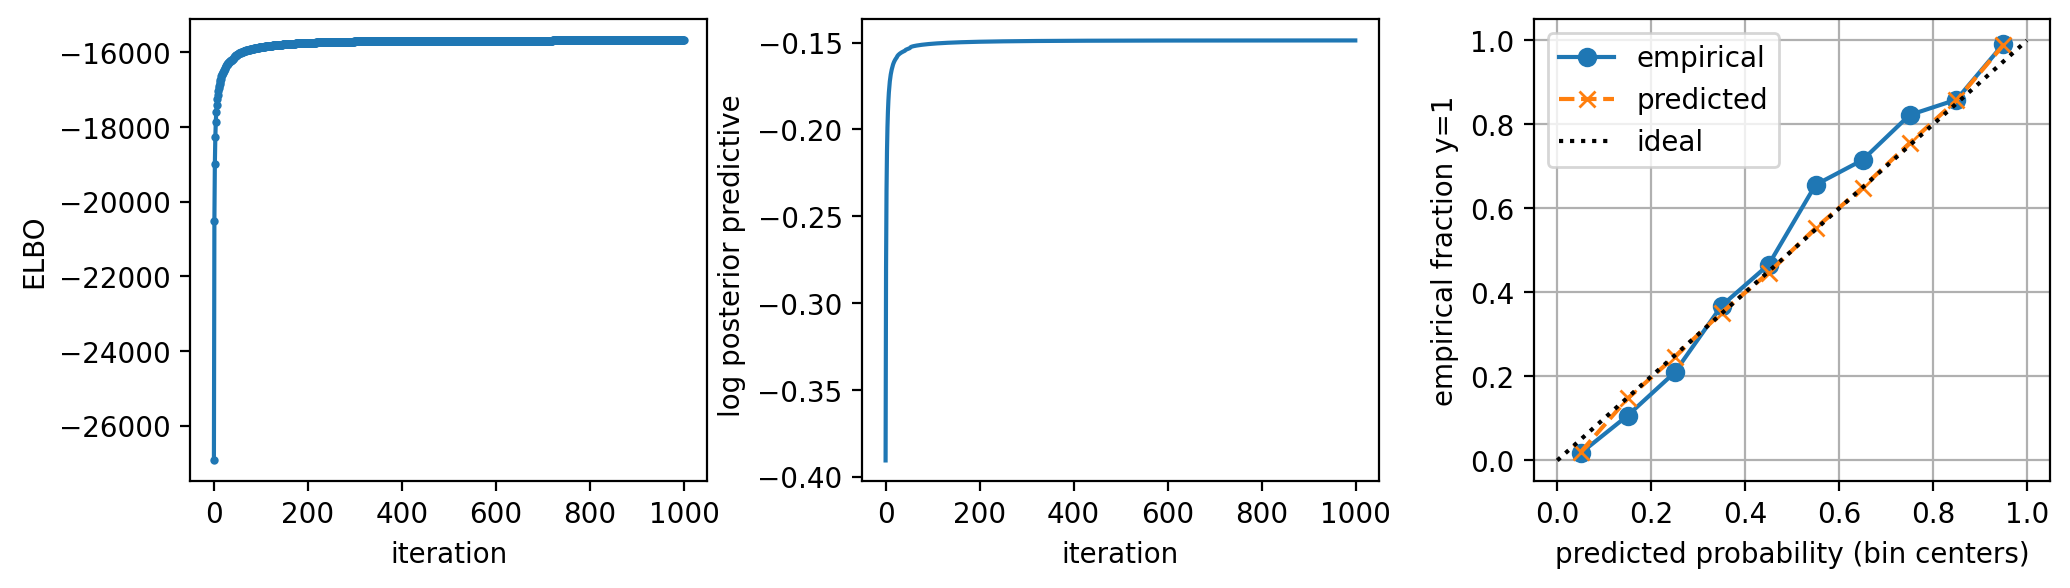

In [ ]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))
plt.subplots_adjust(wspace=0.3)
ax[0].plot(res["elbo_trace"], "-o", markersize=2)
ax[0].set(xlabel="iteration", ylabel="ELBO")
ax[1].plot(-res["nll_trace"])
ax[1].set(xlabel="iteration", ylabel="log posterior predictive ")

bins = 10

i_idx = res["heldout_pairs"][:, 0].astype(int)
j_idx = res["heldout_pairs"][:, 1].astype(int)
mu = res["m_alpha"][j_idx] * (res["m_theta"][i_idx] - res["m_beta"][j_idx])
p_hat = norm.cdf(mu)
y_true = res["votes"][i_idx, j_idx]
bins_edges = np.linspace(0, 1, bins + 1)
bin_idx = np.digitize(p_hat, bins_edges) - 1
bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
emp = []
pred = []
counts = []
for b in range(bins):
    mask = bin_idx == b
    if np.any(mask):
        emp.append(np.mean(y_true[mask]))
        pred.append(np.mean(p_hat[mask]))
        counts.append(np.sum(mask))
    else:
        emp.append(np.nan)
        pred.append(np.nan)
        counts.append(0)

ax[2].plot(bin_centers, emp, "o-", label="empirical")
ax[2].plot(bin_centers, pred, "x--", label="predicted")
ax[2].plot([0, 1], [0, 1], "k:", label="ideal")
ax[2].set(xlabel="predicted probability (bin centers)", ylabel="empirical fraction y=1")

ax[2].legend()
ax[2].grid(True)
plt.savefig("calibration_and_trace_plot.png", bbox_inches="tight", dpi=200)
plt.show()

###  ideology axis

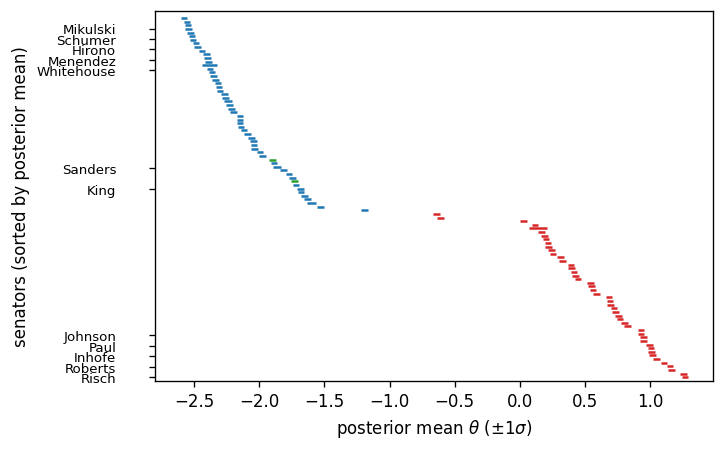

In [ ]:
highlight_n = 5

N = len(res["m_theta"])
party_colors = {"D": "tab:blue", "R": "tab:red", "I": "tab:green"}
colors = [party_colors.get(p) for p in parties]
idx = np.argsort(res["m_theta"])
sorted_m = res["m_theta"][idx]
sorted_v = res["V_theta"][idx]
sorted_colors = [colors[i] for i in idx]
sorted_names = [senators[i] for i in idx]

fig, ax = plt.subplots(dpi=120, figsize=(6, 4))

# switch x and y: x = posterior mean, y = rank
y = np.linspace(0, 103, 100)
x = -sorted_m
xerr = np.sqrt(sorted_v)

# horizontal errorbars
# ax.errorbar(x, y, xerr=xerr, fmt="o", ecolor="lightgray", zorder=1, alpha=0.8)
for xi, yi, xe, c in zip(x, y, xerr, sorted_colors):
    ax.errorbar(
        [xi],
        [yi],
        xerr=[xe],
        color=c,
    )

ax.set(
    xlabel=r"posterior mean $\theta$ ($\pm 1\sigma$)",
    ylabel="senators (sorted by posterior mean)",
)

# only show senator names for the left-most and right-most highlight_n
spacing = 3

left_idx = list(np.arange(0, min(N, highlight_n * spacing), spacing).astype(int))
right_start = max(0, N - highlight_n * spacing)
right_idx = list(np.arange(right_start, N, spacing).astype(int))


tick_idx = left_idx + right_idx
seen = set()
tick_idx_unique = []
for k in tick_idx:
    if k not in seen:
        tick_idx_unique.append(int(k))
        seen.add(k)

tick_positions = [float(k) for k in tick_idx_unique]
tick_labels = [sorted_names[k] for k in tick_idx_unique]

ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels, fontsize=8)
ax.tick_params(axis="y", which="major", pad=12)
ax.tick_params(axis="y", which="major", pad=20)
ax.set_ylim(-1, N + 2)  # padding

# add a tick/label for Sanders
s_idx = sorted_names.index("Sanders")
if s_idx is not None:
    pos = float(s_idx)
    if pos not in tick_positions:
        tick_positions.append(pos)
        tick_labels.append(sorted_names[s_idx])
        order = np.argsort(tick_positions)
        tick_positions = [float(tick_positions[i]) for i in order]
        tick_labels = [tick_labels[i] for i in order]
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels, fontsize=8)
# the other independent
s_idx = sorted_names.index("King")
if s_idx is not None:
    pos = float(s_idx)
    if pos not in tick_positions:
        tick_positions.append(pos)
        tick_labels.append(sorted_names[s_idx])
        order = np.argsort(tick_positions)
        tick_positions = [float(tick_positions[i]) for i in order]
        tick_labels = [tick_labels[i] for i in order]
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels, fontsize=8)

plt.savefig("ideology_axis.png", bbox_inches="tight", dpi=200)
plt.show()

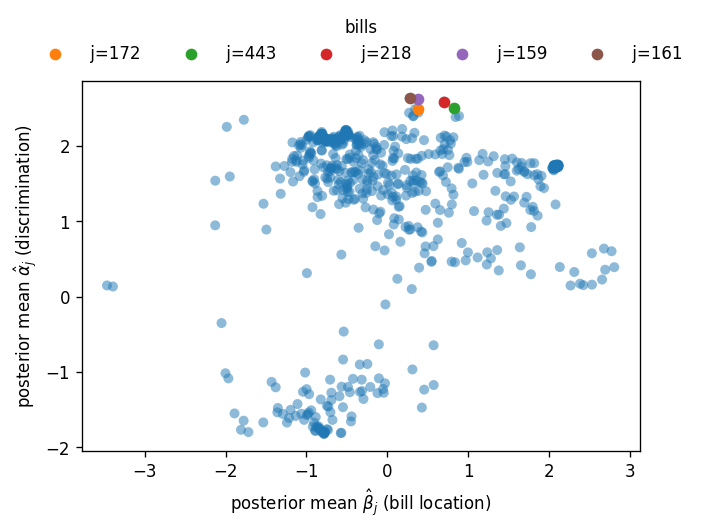

In [169]:
fig, ax = plt.subplots(dpi=120, figsize=(6, 4))
top_k = 5
ax.scatter(-res["m_beta"], res["m_alpha"], alpha=0.5, edgecolors="none")
top_idx = np.argsort(res["m_alpha"])[-top_k:]
for j in top_idx:
    ax.scatter(-res["m_beta"][j], res["m_alpha"][j], label=f" j={j}")
ax.set_xlabel(r"posterior mean $\hat{\beta}_j$ (bill location)")
ax.set_ylabel(r"posterior mean $\hat{\alpha}_j$ (discrimination)")

ax.legend(
    title="bills",
    loc="lower center",
    bbox_to_anchor=(0.5, 1.01),
    ncols=top_k,
    frameon=False,
)
plt.savefig("bill_landscape.png", bbox_inches="tight", dpi=200)
plt.show()

In [168]:
# heldout metrics:
held = res["heldout_pairs"]
i_idx, j_idx = held[:, 0].astype(int), held[:, 1].astype(int)
mu_held = res["m_alpha"][j_idx] * (res["m_theta"][i_idx] - res["m_beta"][j_idx])
p_hat = norm.cdf(mu_held)
y_true = res["votes"][i_idx, j_idx]
eps_nll = 1e-12
nll = -np.mean(
    y_true * np.log(np.clip(p_hat, eps_nll, 1))
    + (1 - y_true) * np.log(np.clip(1 - p_hat, eps_nll, 1))
)  # compute heldout NLL, clip for numerical stability
acc = np.mean((p_hat >= 0.5) == (y_true == 1))
print("heldout NLL:", nll, "heldout acc:", acc)

heldout NLL: 0.14875619931942127 heldout acc: 0.9421343873517787
